In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px
from geopy.geocoders import Nominatim
import folium
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
from notebook.services.config import ConfigManager
ConfigManager().update('notebook', {'limit_output': 3_000_000});

In [4]:
df = pd.read_csv("./data/train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


<AxesSubplot:xlabel='target', ylabel='count'>

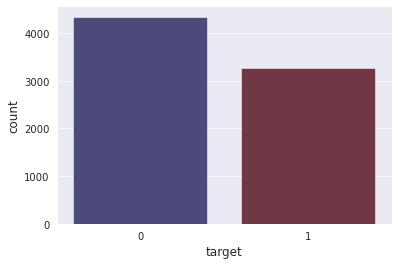

In [21]:
sns.set_style('darkgrid')
sns.countplot(x='target', data=df, palette='icefire')

In [7]:
df_locations_cat = df.groupby(['location', 'target'])[['id']].count().sort_values(by='id', ascending=False)
df_locations_cat

,,id
location,target,
USA,1,67
New York,0,55
USA,0,37
London,0,29
United States,1,27
...,...,...
"Huntsville, Alabama",1,1
Hustletown,1,1
Hyderabad Telangana INDIA,1,1


In [8]:
df_locations_total = df_locations_cat.groupby('location').sum().sort_values(by='id', ascending=False)
df_locations_total

,id
location,
USA,104
New York,71
United States,50
London,45
Canada,29
...,...
Hueco Mundo,1
"Hughes, AR",1
"Huntington, WV",1


In [9]:
def find_long_lat(name: str) -> tuple[int, int]:
    geolocator = Nominatim(user_agent='user_agent')
    location = geolocator.geocode(name)
    if location:
        return location.longitude, location.latitude
    return 0, 0

In [10]:
df_locations_total = df_locations_total.iloc[:100]
df_locations_total

,id
location,
USA,104
New York,71
United States,50
London,45
Canada,29
...,...
North Carolina,5
Philippines,5
"Cleveland, OH",5


In [11]:
df_locations_total['long'] = df_locations_total \
                            .index              \
                            .to_series()        \
                            .apply(lambda x: find_long_lat(x)[0])
df_locations_total['lat'] = df_locations_total  \
                            .index              \
                            .to_series()        \
                            .apply(lambda x: find_long_lat(x)[1])

df_locations_total

,id,long,lat
location,,,
USA,104,-100.445882,39.783730
New York,71,-74.006015,40.712728
United States,50,-100.445882,39.783730
London,45,-0.127647,51.507322
Canada,29,-107.991707,61.066692
...,...,...,...
North Carolina,5,-79.039292,35.672964
Philippines,5,122.731210,12.750349
"Cleveland, OH",5,-81.693681,41.499656


In [12]:
map_ = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2)
# add marker one by one on the map
for i in range(0,len(df_locations_total)):
    folium.Circle(
      location=[df_locations_total.iloc[i]['lat'], df_locations_total.iloc[i]['long']],
      popup=f"{df_locations_total.index[i]}:{df_locations_total.iloc[i]['id']}",
      radius=float(df_locations_total.iloc[i]['id'])*20000,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(map_)

map_

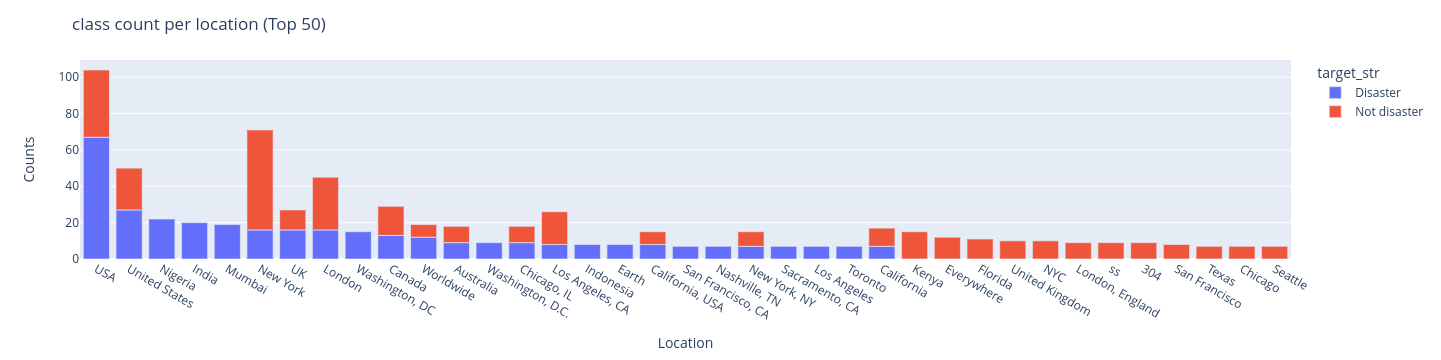

In [38]:
df_loc_cat_new = df_locations_cat.reset_index()
df_loc_cat_new['target_str'] = df_loc_cat_new['target'].apply(lambda x: 'Disaster' if x == 1 else 'Not disaster')
fig = px.bar(df_loc_cat_new[:50], x='location', y='id', color='target_str')
fig.update_layout(
    title='class count per location (Top 50)',
    xaxis_title='Location', 
    yaxis_title = 'Counts', 
)

### Tweet length

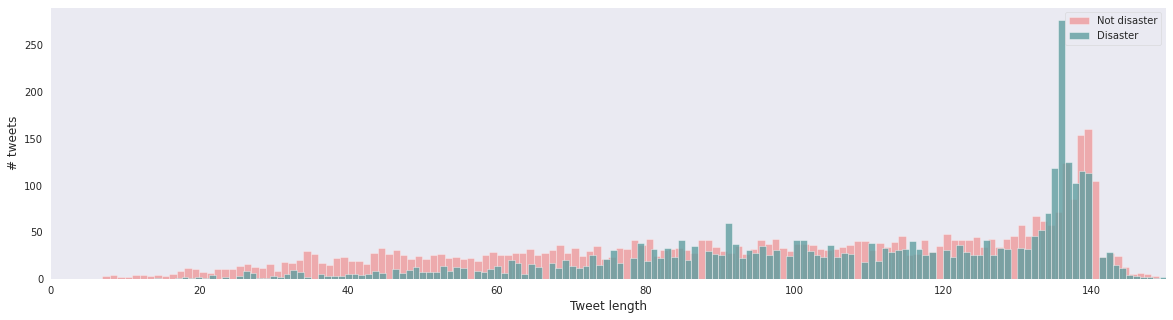

In [28]:
df['tweet_length'] = df['text'].apply(lambda x: len(x))
plt.figure(figsize=(20, 5))
bins = 150
plt.hist(df[df['target'] == 0]['tweet_length'], alpha=0.6, bins=bins, label='Not disaster', color='lightcoral')
plt.hist(df[df['target'] == 1]['tweet_length'], alpha=0.8, bins=bins, label='Disaster', color='cadetblue')
plt.xlabel('Tweet length')
plt.ylabel('# tweets')
plt.legend(loc='upper right')
plt.xlim(0,150)

plt.grid()
plt.show()

In [35]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['unique_word_count'] = df['text'].apply(lambda x: len(set(x.split())))


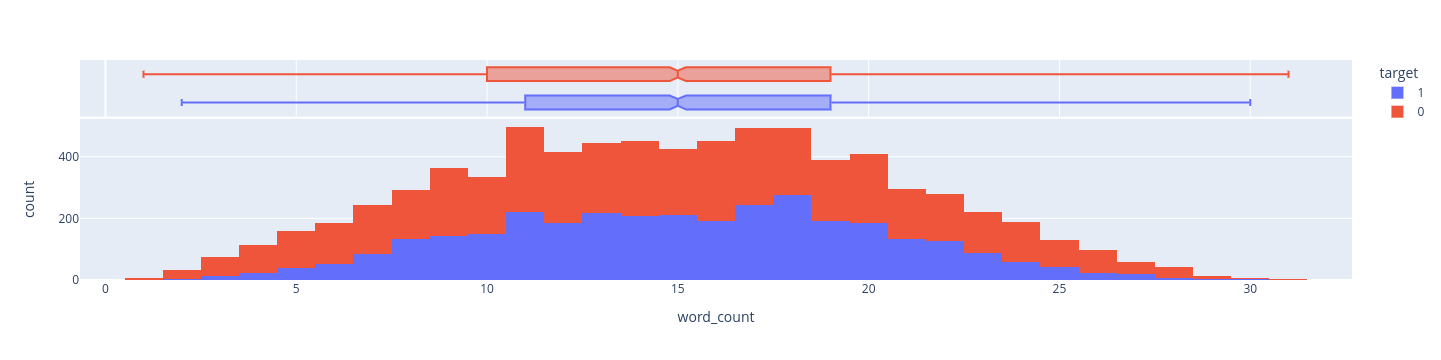

In [36]:
fig1.show()

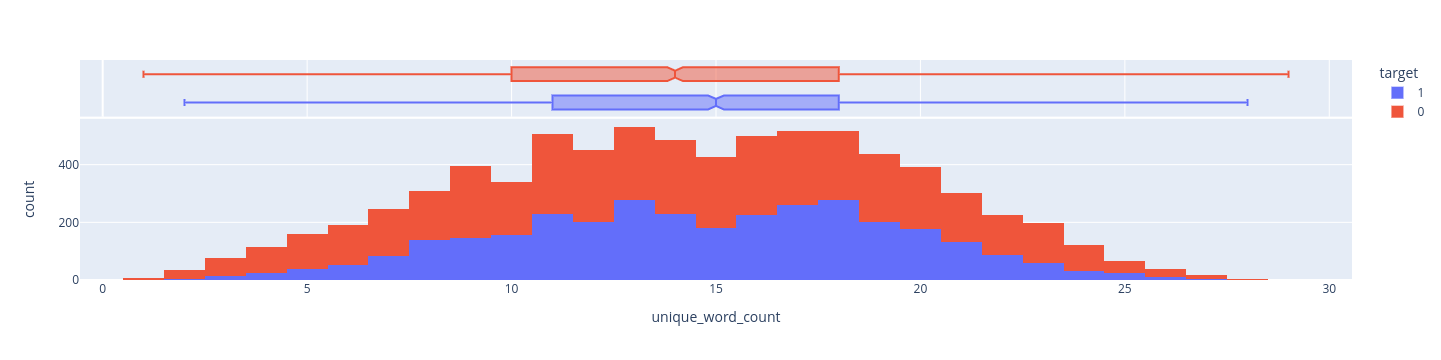

In [37]:
fig2.show()